In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as lf
from lifelines.utils.sklearn_adapter import sklearn_adapter


import sklearn as sk
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

In [2]:
# let's get our data
# 434 -> stroke
# 428 -> heart failure
# 425 -> cardiomyopathy

data = pd.read_csv('clean/afib_428_4_clean.csv')
T, E = data['duration'], data['event']
columns = data.columns
data.describe()

,duration,event,age,sex_0.0,sex_1.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_9.0
count,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000
mean,1154.410163,0.769261,74.229811,0.464961,0.535039,0.462522,0.029713,0.068385,0.044645,0.000249,0.004529,0.389956
std,793.903965,0.421316,11.618050,0.498783,0.498783,0.498606,0.169800,0.252412,0.206528,0.015774,0.067148,0.487752
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,488.000000,1.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1043.500000,1.000000,77.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1737.250000,1.000000,82.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3542.000000,1.000000,103.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
data.head()

,duration,event,age,sex_0.0,sex_1.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_9.0
0,416.0,1.0,84.0,1,0,1,0,0,0,0,0,0
1,923.0,1.0,87.0,1,0,1,0,0,0,0,0,0
2,857.0,1.0,92.0,1,0,1,0,0,0,0,0,0
3,310.0,1.0,80.0,0,1,1,0,0,0,0,0,0
4,1765.0,1.0,81.0,0,1,1,0,0,0,0,0,0


In [4]:
data.shape[0] # number of patients

20092

In [5]:
censorship_counts = data['event'].value_counts()
censor_rate = censorship_counts[0] / censorship_counts.sum()
print('Censor Rate:', str(round(censor_rate, 2)*100) + '%')

Censor Rate: 23.0%


In [6]:
censorship_counts

1.0    15456
0.0     4636
Name: event, dtype: int64

In [7]:
X = pd.DataFrame(data.drop('duration', axis=1))
Y = pd.DataFrame(data['duration'])

X['age'] = preprocessing.scale(X['age'])
X

,event,age,sex_0.0,sex_1.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_9.0
0,1.0,0.840970,1,0,1,0,0,0,0,0,0
1,1.0,1.099195,1,0,1,0,0,0,0,0,0
2,1.0,1.529571,1,0,1,0,0,0,0,0,0
3,1.0,0.496670,0,1,1,0,0,0,0,0,0
4,1.0,0.582745,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20087,0.0,-0.708382,0,1,0,0,0,0,0,0,1
20088,0.0,1.185270,1,0,1,0,0,0,0,0,0
20089,0.0,1.443496,1,0,1,0,0,0,0,0,0
20090,0.0,-0.708382,1,0,0,1,0,0,0,0,0


In [8]:
trainX, valX, trainY, valY = model_selection.train_test_split(X, Y)
trainX, valX, trainY, valY = pd.DataFrame(trainX), pd.DataFrame(valX), pd.DataFrame(trainY), pd.DataFrame(valY)

trainX.columns = columns[1:] 
valX.columns = columns[1:]

### Linear Regression

In [9]:
lrg = LinearRegression()
lrg.fit(trainX, trainY)
print(lf.utils.concordance_index(valY, lrg.predict(valX), event_observed=valX['event']))

0.5711784138300227


### Cox Regression

In [10]:
CoxRegression = sklearn_adapter(lf.CoxPHFitter, event_col='event')
sk_cph = CoxRegression(penalizer=.1)

sk_cph.fit(trainX, trainY)
sk_cph.lifelines_model.print_summary()

In [11]:
sk_cph.score(valX, valY)

0.6212566458136097

In [12]:
'''
cph = lf.CoxPHFitter(penalizer=.1)
cph.fit(data, 'duration','event')
cph.check_assumptions(data)
'''

"\ncph = lf.CoxPHFitter(penalizer=.1)\ncph.fit(data, 'duration','event')\ncph.check_assumptions(data)\n"

In [13]:
#sk_cph.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

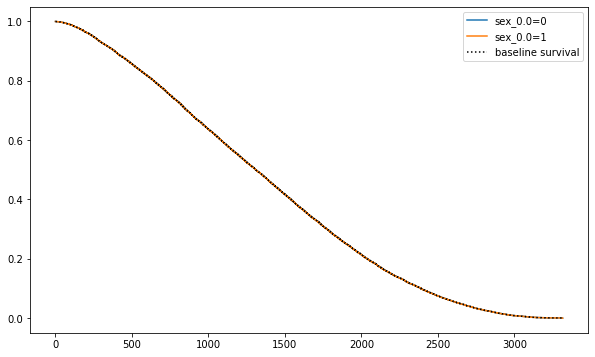

In [14]:
sk_cph.lifelines_model.plot_covariate_groups('sex_0.0', values=[0,1], figsize=(10,6))

### Weibull AFT

In [15]:
'''
# get best parameters for WeibullAFT
WeibullAFT = sklearn_adapter(lf.WeibullAFTFitter, event_col='event')
sk_wf = WeibullAFT()

clf = model_selection.GridSearchCV(sk_wf, {
    "penalizer":10.0 ** np.arange(-2, 3),
    "l1_ratio": [0, 1/3, 2/3],
    "model_ancillary":[True,False],
}, cv=4)
clf.fit(trainX, trainY)
print(clf.best_estimator_)
'''

'\n# get best parameters for WeibullAFT\nWeibullAFT = sklearn_adapter(lf.WeibullAFTFitter, event_col=\'event\')\nsk_wf = WeibullAFT()\n\nclf = model_selection.GridSearchCV(sk_wf, {\n    "penalizer":10.0 ** np.arange(-2, 3),\n    "l1_ratio": [0, 1/3, 2/3],\n    "model_ancillary":[True,False],\n}, cv=4)\nclf.fit(trainX, trainY)\nprint(clf.best_estimator_)\n'

In [16]:
WeibullAFT = sklearn_adapter(lf.WeibullAFTFitter, event_col='event')

sk_wf = WeibullAFT(penalizer=.1)
sk_wf.fit(trainX, trainY)
sk_wf.lifelines_model.print_summary()

In [17]:
sk_wf.score(valX, valY)

0.6210760972146244

In [18]:
sk_wf.lifelines_model.mean_survival_time_

1340.693932524932

In [19]:
sk_wf.lifelines_model.median_survival_time_

1236.4899736630748

In [20]:
#sk_wf.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

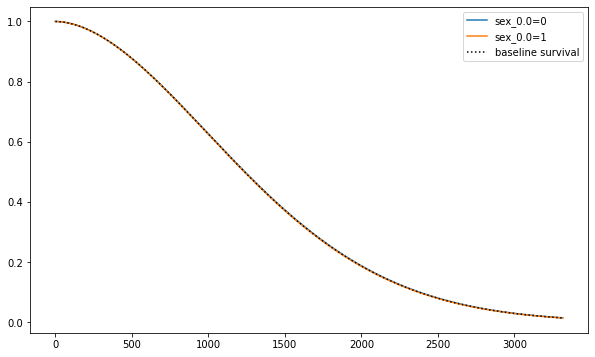

In [21]:
sk_wf.lifelines_model.plot_covariate_groups('sex_0.0', values=[0,1], figsize=(10,6))

### Log-Normal AFT

In [22]:
LogNormAFT = sklearn_adapter(lf.LogNormalAFTFitter, event_col='event')

sk_lnf = LogNormAFT()
sk_lnf.fit(trainX, trainY)
sk_lnf.lifelines_model.print_summary()

C:\Users\tug84786\AppData\Local\Continuum\miniconda3\lib\site-packages\lifelines\fitters\__init__.py:1953: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with LogNormalAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)


In [23]:
sk_lnf.score(valX, valY)

0.6200263426378265

In [24]:
sk_lnf.lifelines_model.mean_survival_time_

1512.8870753444496

In [25]:
sk_lnf.lifelines_model.median_survival_time_

1107.0107693082116

In [26]:
#sk_lnf.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

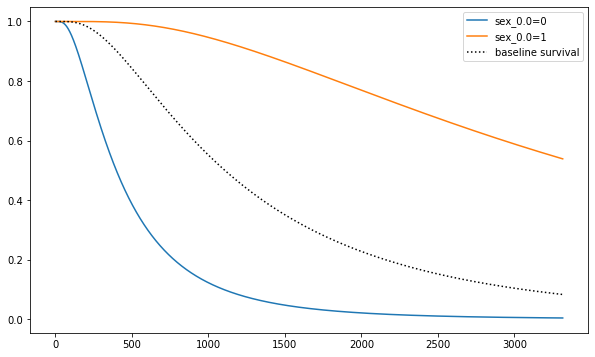

In [27]:
sk_lnf.lifelines_model.plot_covariate_groups('sex_0.0', values=[0,1], figsize=(10,6))

### Log-Logistic AFT

In [28]:
LogLogAFT = sklearn_adapter(lf.LogLogisticAFTFitter, event_col='event')

sk_llf = LogLogAFT()
sk_llf.fit(trainX, trainY)
sk_llf.lifelines_model.print_summary()

C:\Users\tug84786\AppData\Local\Continuum\miniconda3\lib\site-packages\lifelines\fitters\__init__.py:1953: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with LogLogisticAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, utils.StatisticalWarning)


In [29]:
sk_llf.score(valX, valY)

0.6208324944293522

In [30]:
sk_llf.lifelines_model.mean_survival_time_

1614.4726249380128

In [31]:
sk_llf.lifelines_model.median_survival_time_

1188.5078961812626

In [32]:
#sk_llf.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

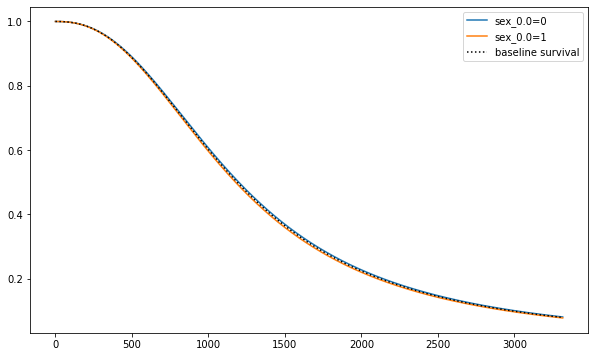

In [33]:
sk_llf.lifelines_model.plot_covariate_groups('sex_0.0', values=[0,1], figsize=(10,6))

### Compare AFTs

In [34]:
print('Weibull:', sk_wf.lifelines_model.log_likelihood_)
print('Log-Norm:', sk_lnf.lifelines_model.log_likelihood_)
print('Log-Log:', sk_llf.lifelines_model.log_likelihood_)

Weibull: -93505.34822378676
Log-Norm: -95137.09145757424
Log-Log: -94557.12881772015


### Aalen's Additive Regression

In [35]:
aff = lf.AalenAdditiveFitter(coef_penalizer=.05)
aff.fit(data, duration_col='duration', event_col='event')
aff.print_summary()

### K-Fold Cross-Validation

##### Aalen's

In [36]:
#print(np.mean(lf.utils.k_fold_cross_validation(lf.AalenAdditiveFitter(coef_penalizer=.1), data, duration_col='duration', event_col='event', scoring_method='concordance_index')))

##### Weibull AFT

In [37]:
#print(np.mean(lf.utils.k_fold_cross_validation(lf.WeibullAFTFitter(), data, duration_col='duration', event_col='event', scoring_method='concordance_index')))

##### Cox

In [38]:
#print(np.mean(lf.utils.k_fold_cross_validation(lf.CoxPHFitter(penalizer=.05), data, duration_col='duration', event_col='event', scoring_method='concordance_index')))

### scikit-survival models

In [39]:
'''
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")
'''

'\n%matplotlib inline\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport pandas\nimport seaborn as sns\nfrom sklearn.model_selection import ShuffleSplit, GridSearchCV\n\nfrom sksurv.datasets import load_veterans_lung_cancer\nfrom sksurv.column import encode_categorical\nfrom sksurv.metrics import concordance_index_censored\nfrom sksurv.svm import FastSurvivalSVM\n\nsns.set_style("whitegrid")\n'

In [40]:
'''
data['event'] = data['event'].astype(bool)
X = pd.DataFrame(data.drop(['duration','event'], axis=1))
Y = pd.DataFrame(data[['event','duration']])

X['age'] = preprocessing.scale(X['age'])

trainX, valX, trainY, valY = model_selection.train_test_split(X, Y)
trainX, valX, trainY, valY = pd.DataFrame(trainX), pd.DataFrame(valX), pd.DataFrame(trainY), pd.DataFrame(valY)

trainY = trainY.to_records(index=False)

valY = valY.to_records(index=False)

trainX.columns=['age','c1','c2','s1','s2','r1','r2','r3','r4','r5','r6','r9']
valX.columns=['age','c1','c2','s1','s2','r1','r2','r3','r4','r5','r6','r9'] 
'''

"\ndata['event'] = data['event'].astype(bool)\nX = pd.DataFrame(data.drop(['duration','event'], axis=1))\nY = pd.DataFrame(data[['event','duration']])\n\nX['age'] = preprocessing.scale(X['age'])\n\ntrainX, valX, trainY, valY = model_selection.train_test_split(X, Y)\ntrainX, valX, trainY, valY = pd.DataFrame(trainX), pd.DataFrame(valX), pd.DataFrame(trainY), pd.DataFrame(valY)\n\ntrainY = trainY.to_records(index=False)\n\nvalY = valY.to_records(index=False)\n\ntrainX.columns=['age','c1','c2','s1','s2','r1','r2','r3','r4','r5','r6','r9']\nvalX.columns=['age','c1','c2','s1','s2','r1','r2','r3','r4','r5','r6','r9'] \n"

##### Cox variation with elastic net penalty

In [41]:

#from sksurv.linear_model import CoxnetSurvivalAnalysis

#cphnet = CoxnetSurvivalAnalysis()
#cphnet.fit(trainX, trainY)

In [42]:
#cphnet.score(valX, valY)

##### sksurv's Cox implementation

In [43]:
#from sksurv.linear_model import CoxPHSurvivalAnalysis

#cph = CoxPHSurvivalAnalysis()
#pd.Series(cph.fit(trainX, trainY))

In [44]:
#cphnet.score(valX, valY)